# Modular flow system

I have decided to adapt the design system from Jina into this repo, at least for prototyping purposes. Their distributed systems approach seems quite good but is too muc complexity for me to add right away. Insetead I'm going to replicate the essential design pattern, that of Flows and Executors.

**Flows** are specific patterns of data manipulation and storage. **Executors** are the operators that transform the data within the flow. 

There are two core flows to any search system: indexing, and querying. The plan here is to make executors that can be composed into flows and then compose the flows into a UI that supports querying and, to some extent, indexing as well.

The core executors for this use case are:
 - Loader
 - Crafter
 - Encoder
 - Indexer
 - Ranker
 - Gateway
 
In this file I try to build these so that the Jupyter notebook itself can be run as a Flow for indexing and then querying. From there it should be easy to abstract the functions and classes and messaging or whatever is necessary for microservices etc.

In [ ]:
# move these to main function eventually but for now we're going in notebook order
args = {
    "path": "/home/mage/Pictures/memes/",
    "query": "cat laughing",
}

## Loader

The loader takes a directory or list of image files and checks them against database or checkpoint. If there is a saved checkpoint and the files haven't changed, it loads the checkpoint and sends the data directly to Ranker. If not, it sends them to Crafter. Ideally  it could send new images to Crafter and load dictionary of old images at the same time, without re-encoding old images.

The process of indexing could actually happen in the background while querying happens on the old index! This means putting the logic in the Flow rather than the Loader, I suppose.

Maybe use `shelve` module to build dictionary `{filename_timestamp : vector}` to databse as a simple version control mechanism. Then, if any filenames exist but with a different timestamp, we load those under their own key. And we can throw out any filename_timestamp that doesn't exist, before indexing. 

In [ ]:
from pathlib import Path

path = Path(args['path'])

In [ ]:
def slugify(filepath):
    return f'{filepath.stem}_{str(filepath.stat().st_mtime).split(".")[0]}'

In [ ]:
# filenames = path.iterdir()
def get_image_files(path):
    return [(f, slugify(f)) for f in path.rglob('*') if f.suffix in ['.jpg', '.png', '.jpeg']]

In [ ]:
filenames = get_image_files(path)

In [ ]:
len(filenames)

3697

So we have a list of paths and slugified filenames from the folder. We want to see if there's an archive, so that we don't have to recalculate tensors for images we've seen before. Then we want to pass that directly to the indexer, but send the new images through the crafter and encoder first.

This is what that code looks like now, roughly:

In [ ]:
savefile = path/'memery.pt'
savefile_backup = path/'memery-bak.pt'
savetree = path/'memery.ann'

In [ ]:
# delete the old ones with a different format lol
#savefile.unlink()

In [ ]:
if savefile.exists(): 
    save_dict = torch.load(savefile)
    image_names = [k for k in save_dict.keys()]
    image_features = torch.stack([v for v in save_dict.values()]).to(device)
elif savefile_backup.exists:
    save_dict = torch.load(savefile_backup)
    image_names = [k for k in save_dict.keys()]
    image_features = torch.stack([v for v in save_dict.values()]).to(device)
else:
    image_features = torch.tensor(()).to(device)
    with torch.no_grad():
        imagefiles=torchvision.datasets.ImageFolder(root=path, transform=preprocess)
        img_loader=torch.utils.data.DataLoader(imagefiles, batch_size=128, shuffle=False, num_workers=4)
        for images, labels in tqdm(img_loader):
            batch_features = model.encode_image(images)
            image_features = torch.cat((image_features, batch_features)).to(device)

    image_names = [Path(f[0]) for f in imagefiles.imgs]
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    save_dict = {str(k):v for k, v in zip(image_names, image_features)}
    torch.save(save_dict, savefile)

NameError: name 'torch' is not defined

But I need to separate out the logic for the crafter and encoder from the simple loading of archives and pictures. This component should only provide the dictionary of archived CLIP embeddings, the treemap (eventually) and the locations of the new images to review, and let the downstream components deal with them.

In [ ]:
import torch
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def files_and_archive_loader(filenames, device):
    if savefile.exists():
        save_dict = torch.load(savefile)
    elif savefile_backup.exists():
        save_dict = torch.load(savefile_backup)
    else:
        save_dict = {}
    
  
    
    if save_dict == {}:
        archive_embeddings = torch.tensor(()).to(device)
        archive_files = [k for k in save_dict.keys()]
    else:
        archive_embeddings = torch.stack([v for v in save_dict.values()]).to(device) 
        archive_files = []
        
    new_files = [(str(path), slug) for path, slug in filenames if slug not in archive_files]
    
    return(archive_files, archive_embeddings, new_files)

In [ ]:
archive_files, archive_embeddings, new_files = loader(filenames, device)

In [ ]:
print(len(new_files),len(archive_files),archive_embeddings.shape)

3697 0 torch.Size([0])


## Crafter

Takes a list of image filenames and transforms them to batches of the correct dimensions for CLIP. Need to figure out a way around torchvision's loader  idiosyncrasies here: currently it just loads images from subfolders, needs to operate okay if pointed at a single folder of images, or recursively, or an arbitrary list of files.

Then, too, it would be nice to eventually putthis work on the client computer using torchscript or something. So that it only sends 224x224x3 images over the wire. And we only have to compute those once per image, since we're storing a database of finished vectors which should be even smaller


Previously I've been using ImageFolder from the pytorch vision datasets library. I want to either inherit from that, or form its parent Dataset, and define a different loading method . The Dataset returns just a dictionary of indices and datapoints; in this case, we want to keep an ordered list of `new_files` and be able to pass them one by one, with index, to the DataLoader which will do batching &c.

The main trick here is that the ImageFolder does preprocessing using torchvision transforms, and I want to be able to do that without using its peculiar subfolder structure. So let's print out the source of ImageFolder here and see what it looks like:

In [ ]:
torchvision.datasets.ImageFolder??

Init signature: torchvision.datasets.ImageFolder(*args, **kwds)
Source:        
class ImageFolder(DatasetFolder):
    """A generic data loader where the images are arranged in this way: ::

        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png

        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png

    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)

     Attributes:
        classes (list): List of the c

That doesn't tell me much. The transform is clearly just a Callable function but it's passed to the DatasetFolder I guess? And the rest of of it seems to be accessing the `super` function. So I need to look at the class it inherits from, `DatasetFolder`, and its parent `VisionDataset`.

...

Okay. The `VisionDataset` owns the repr function and passes the transforms, b
ut otherwise expects subclasses to implement the `__getitem__` and `__init__` functions. The `DatasetFolder` defines the way classes are extracted from folder names, and passes the samples along with their class. Overriding the `DatasetFolder.make_dataset` method, and `DatasetFolder.find_classes` which it uses, is the way to do a different directory structure. And since we already have all the paths, I guess all we have to do is copy over the logic that checks for bad files, and simplify the logic that applies classes to indices. After all, on a problem like this we're really just using one class per image!

In [ ]:
def make_dataset(new_files):
    '''Returns a list of samples of a form (path_to_sample, class) and in 
    this case the class is just the filename'''
    instances = []
    slug_to_idx = []
    for i, f in enumerate(new_files):
        path, slug = f
        instances.append((str(path), i))
        slug_to_idx.append((slug, i))
    return(instances, slug_to_idx)

In [ ]:
instances, slug_to_idx = make_dataset(new_files)

In [ ]:
instances[:5]

[('/home/mage/Pictures/memes/Nokia/Pictures/signal-2020-05-08-082518.jpg', 0),
 ('/home/mage/Pictures/memes/Nokia/Pictures/signal-2020-04-30-084638.jpg', 1),
 ('/home/mage/Pictures/memes/Nokia/Pictures/signal-2019-10-10-115435.jpg', 2),
 ('/home/mage/Pictures/memes/Nokia/Pictures/signal-2020-05-05-123353.jpg', 3),
 ('/home/mage/Pictures/memes/Nokia/Pictures/signal-2020-05-01-120121.jpg', 4)]

In [ ]:
slug_to_idx[:5]

[('signal-2020-05-08-082518_1588994877', 0),
 ('signal-2020-04-30-084638_1589463186', 1),
 ('signal-2019-10-10-115435_1570731409', 2),
 ('signal-2020-05-05-123353_1588703633', 3),
 ('signal-2020-05-01-120121_1588356089', 4)]

In fact, I can skip this entirely and just pass `new_files` to a subclass of ImageFolder and override `make_dataset` by reading it instead of root!

I'll try this but then I gotta run for the day. At least I know what's up 

In [ ]:
class ImagePathClassList(torchvision.datasets.ImageFolder):

    def __init__(
            self,
            new_files: list,
            slug_to_idx: list,
#             transforms
    ):
        super(ImagePathClassList, self).__init__(new_files, loader, 
#                                           transform=transforms,
                                            )
        class_to_idx = slug_to_idx
        self.samples = make_dataset(new_files)
        self.imgs = self.samples

In [ ]:
ImagePathClassList(instances, slug_to_idx)

TypeError: scandir: path should be string, bytes, os.PathLike, integer or None, not list

Hmm. Looks like I don't know how to inherit from this class properly. Maybe i need to do it from `DatasetFolder`? That is where the functions I need to override exist, after all. Hmm.

No, after looking closer at it there is a bunch of stuff in that class that I don't need. Maybe I should start with the simplest option, just overriding the main methods on a VisionDataset, and copy over whatever I actually do need from the more advanced classes.

In [ ]:
from torchvision.datasets import VisionDataset
from PIL import Image

In [ ]:
from IPython.display import Image as IMG

In [ ]:
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
class DatasetImagePaths(VisionDataset):
    def __init__(self, new_files, transforms = None):
        super(DatasetImagePaths, self).__init__(new_files, transforms=transforms)
        samples, slugs = make_dataset(new_files)
        self.samples = samples
        self.slugs = slugs
        self.loader = pil_loader
        self.root = 'file dataset'
    def __len__(self):
        return(len(self.samples))
        
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transforms is not None:
            sample = self.transforms(sample)
        return sample, target

In [ ]:
crafted = DatasetImagePaths(new_files)

In [ ]:
crafted[10][0].show()

AttributeError: 'Tensor' object has no attribute 'show'

Okay, that seems to work decently. Test with transforms, which I will just find in CLIP source code and copy over, to prevent having to import CLIP in this executor.

In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

In [ ]:
def clip_transform(n_px):
    return Compose([
        Resize(n_px, interpolation=Image.BICUBIC),
        CenterCrop(n_px),
        lambda image: image.convert("RGB"),
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

In [ ]:
crafted = DatasetImagePaths(new_files, clip_transform(224))

In [ ]:
crafted[10][0].shape

torch.Size([3, 224, 224])

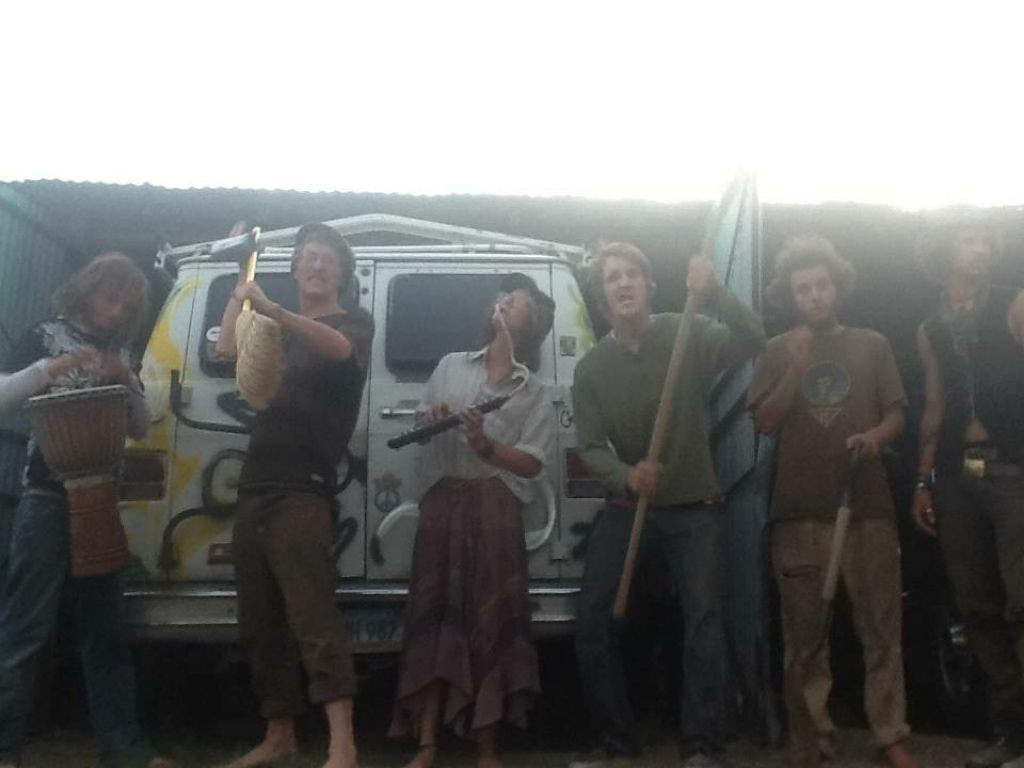

In [ ]:
img = IMG(new_files[10][0])
display(img)

In [ ]:
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(crafted[10][0])
img.show()

In [ ]:
def crafter(new_files, device): 
    with torch.no_grad():
        imagefiles=DatasetImagePaths(new_files, clip_transform(224))
        img_loader=torch.utils.data.DataLoader(imagefiles, batch_size=128, shuffle=False, num_workers=4)
    return(img_loader)

In [ ]:
img_loader = crafter(new_files, device)

In [ ]:
img_loader

## Encoder

CLIP wrapper takes batched tensors or text queries and returns batched 512-dim vectors. size of batch depends on GPU, but if we're putting all that on a server anyway it's a matter of accounting. Does batching go here though? Or in the crafter?

cool thing here is we can use one encoder for both image and text, just check type on the way in. but first probably keep it simple and make two functions.

could index previous queries as vectors in a different map and use for predictive/history -- keep a little database of previous queries already in vector format and their ranked NNs, so that the user can see history offline?

In [ ]:
import clip
from tqdm import tqdm
model, preprocess = clip.load("ViT-B/32", device)

In [ ]:
def image_encoder(img_loader, device):
    image_embeddings = torch.tensor(()).to(device)
    with torch.no_grad():
        for images, labels in tqdm(img_loader):
            batch_features = model.encode_image(images)
            image_embeddings = torch.cat((new_embeddings, batch_features)).to(device)
    
    image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
    return(new_embeddings)

In [ ]:
new_embeddings = image_encoder(img_loader, device)

 72%|███████▏  | 21/29 [00:26<00:05,  1.39it/s]/home/mage/.local/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/mage/.local/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 29/29 [00:32<00:00,  1.14s/it]


In [ ]:
def text_encoder(text, device):
    with torch.no_grad():
        text = clip.tokenize(text).to(device)
        text_features = model.encode_text(text)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    return(text_features)

## Indexer

Annoy treemap or FAISS or other solutions. Given a dataset of tensors, returns a dictionary or database or treemap structure, something that is searchable for later. It would be nice to be able to diff this somehow, or make sure that it's up-to-date. Maybe keeping two copies is okay? One for backup and quick-searching, one for main search once it's indexed any new images. 

This executor `needs` both Encoder and Loader to send it the new and old vectors, respectively. So it either is, or is preceded by, some kind of **join_all** component that can makesure we're not missing new data before handing it over to the indexer. Hm

In [ ]:
def join_all(new_embeddings, archive)

In [ ]:
from annoy import AnnoyIndex

In [ ]:
def build_treemap(new_embeddings):
    treemap = AnnoyIndex(512, 'angular')
    print("building trees...")
    for i, img in tqdm(enumerate(new_embeddings)):
        treemap.add_item(i, img)

    # Build the treemap, with 10 trees rn
    treemap.build(10)
    return(treemap)
# # Save annoy index and list of filenames
# self.treemap.save(str(savefile))  

In [ ]:
t = build_treemap(new_embeddings)

20it [00:00, 190.35it/s]

building trees...


3697it [00:18, 202.75it/s]


In [ ]:
t.get_n_items(), t.get_n_trees()

(3697, 10)

## Ranker

Takes a query and an index and finds the nearest neighbors or most similar scores. Ideally this is just a simple Annoy `get_nns_by_vector`, or in the simple case a similarity score across all the vectors.

In [ ]:
def ranker(query_vec, treemap):
    nn_indexes = treemap.get_nns_by_vector(query_vec[0], treemap.get_n_items())
    return(nn_indexes)

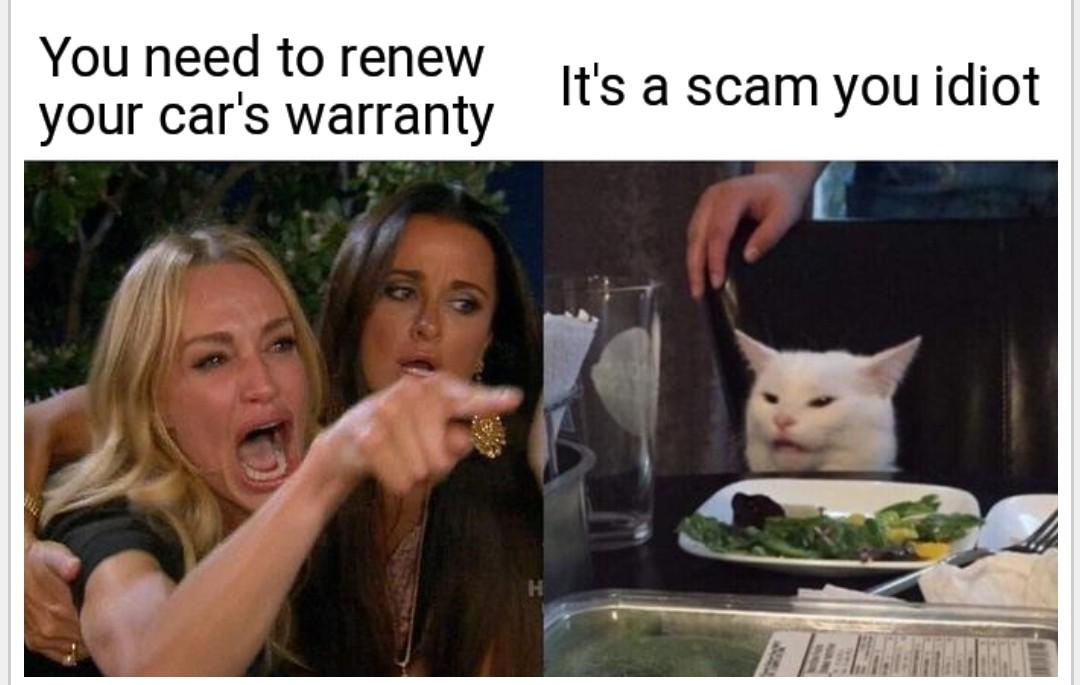

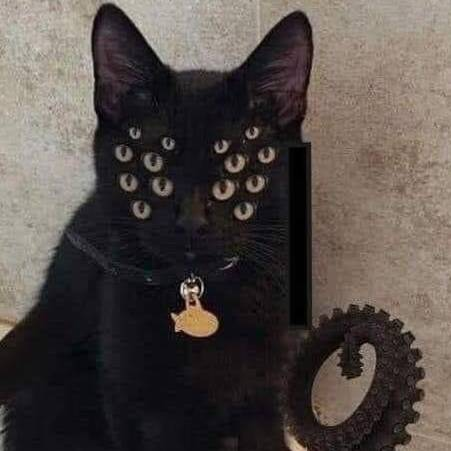

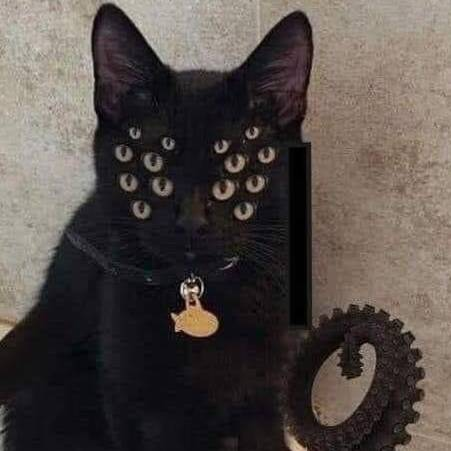

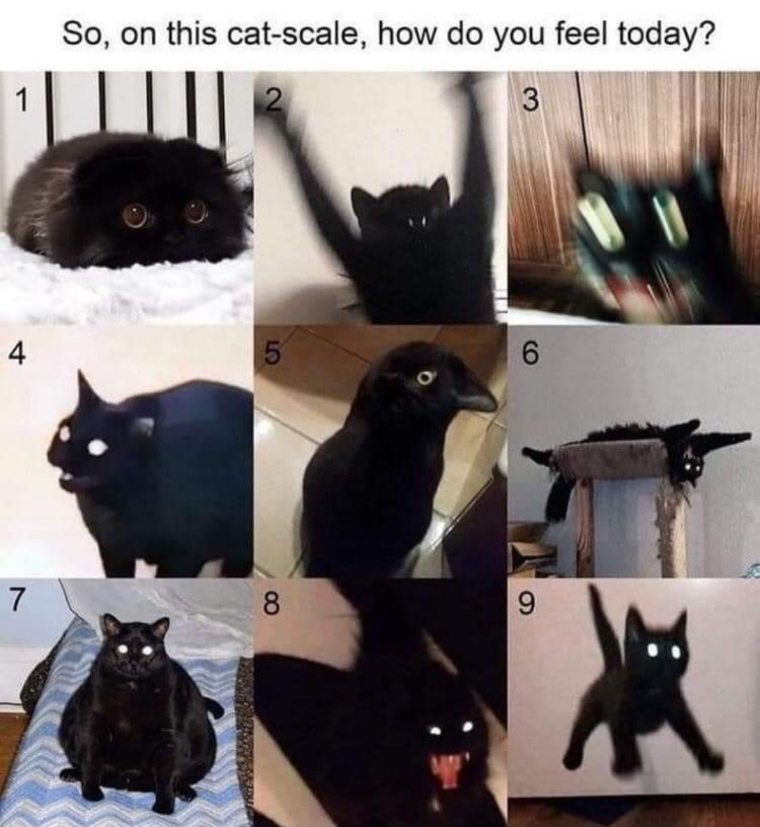

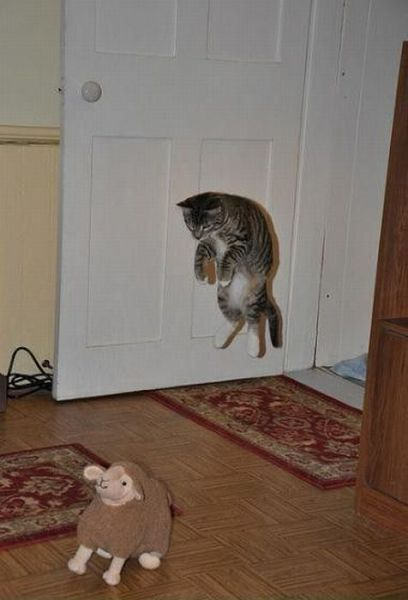

In [ ]:
query_vec = text_encoder('scary cat', device)
indexes = ranker(query_vec, treemap)
for i in indexes[:5]:
    display(IMG(new_files[i][0], width=200))

I think we have to call that a success!

## Gateway

Takes a query and processes it through either Indexing Flow or Querying Flow, passing along arguments. The main entrypoint for each iteration of the index/query process.

Querying Flow can technically process either text or image search, becuase the CLIP encoder will put them into the same embedding space. So we might as well build in a method for either, and make it available to the user, since it's impressive and useful and relatively easy to build.

Eventually the Gateway process probably needs to be quite complicated, for serving all the different users and for delivering REST APIs to different clients. For now we will run this locally, in a notebook. Then build out a GUI from there using `mediapy` or `widgets`. That should reveal the basic necessities of the UI, and then we can separate out the GUI client from the server.

In [ ]:
def queryFlow: 

## Interactive process
Currently the objective is to take the following inputs:
- a location with images
- a text or image query,

and return the following outputs:
- a list of image files within that location ranked by similarity to that query,

with a minimum of duplicated effort, and a general ease-of-use for both the programmer and the casual API user.

## TODO:

- Flows
- Rough interactive GUI
- Code for join archived data to new data wihtout losing organization
- Code for saving indexes to archive
- Type annotations
- Cleanup repo
